# Gearbox Analysis

The National Renewable Energy Laboratory (NREL) Gearbox Reliability Collaborative (GRC) dataset

In [1]:
# Libraries Import

from nptdms import TdmsFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import IsolationForest
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
warnings.filterwarnings('ignore')


---

## Transforming the data into a suitable format for analysis

In [2]:
# Function to read tdms file and return pandas dataframe

def read_tdms(path):
    # Open the TDMS file
    tdms_file = TdmsFile.read(path)

    # Get a list of all groups in the TDMS file
    groups = tdms_file.groups()

    # Initialize an empty dictionary to store channel data
    channel_data = {}

    # Access data in each group
    for group in groups:
        channels = group.channels()
        for channel in channels:
            channel_name = channel.path.split("/")[-1][1:-1]  # Extract the channel name
            data = group[channel_name].data  # Access the channel data
            
            # Store channel data in the dictionary
            channel_data[channel_name] = data

    df = pd.DataFrame(channel_data) # Create Pandas DataFrame
    return df

In [3]:
# Function to plot bearing loads (TRB Signal)
def plot_trb(df):
        time_delta = df['LabVIEW Timestamp'] - df['LabVIEW Timestamp'].iloc[0]

        # Subplot titles
        subplot_titles = ["Thin End Upwind", "Thick End Upwind", "Thin End Downwind", "Thick End Downwind"]

        # Data columns and their corresponding labels and colors
        data_info = [
                # For Thin End Upwind
                [('TRB_Up_00_A', 'Upwind at 0°', '#F95B3A'),
                ('TRB_Up_90_A', 'Upwind at 90°', '#F9B347'),
                ('TRB_Up_180_A', 'Upwind at 180°', '#25CAA0'),
                ('TRB_Up_270_A', 'Upwind at 270°', '#20A9CA')],
                # For Thick End Upwind
                [('TRB_Up_00_B', 'Upwind at 0°', '#F95B3A'),
                ('TRB_Up_90_B', 'Upwind at 90°', '#F9B347'),
                ('TRB_Up_180_B', 'Upwind at 180°', '#25CAA0'),
                ('TRB_Up_270_B', 'Upwind at 270°', '#20A9CA')],
                # For Thin End Downwind
                [('TRB_Dwn_00_D', 'Downwind at 0°', '#F95B3A'),
                ('TRB_Dwn_90_D', 'Downwind at 90°', '#F9B347'),
                ('TRB_Dwn_180_D', 'Downwind at 180°', '#25CAA0'),
                ('TRB_Dwn_270_D', 'Downwind at 270°', '#20A9CA')],
                # For Thick End Downwind
                [('TRB_Dwn_00_C', 'Downwind at 0°', '#F95B3A'),
                ('TRB_Dwn_90_C', 'Downwind at 90°', '#F9B347'),
                ('TRB_Dwn_180_C', 'Downwind at 180°', '#25CAA0'),
                ('TRB_Dwn_270_C', 'Downwind at 270°', '#20A9CA')]
        ]

        fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=100)
        axs = axs.flatten()  # Flatten to iterate easily

        for ax_idx, ax in enumerate(axs):
                ax.set_title(subplot_titles[ax_idx], fontname='Times New Roman', family='serif', size=12)
                for col, label, color in data_info[ax_idx]:
                        ax.scatter(time_delta, df[col], s=8, color=color, label=label)

                        ax.set_ylim([-0.1, 1])
                        ax.set_xlim([0, 1])
                        ax.set_xticklabels(np.around(ax.get_xticks(), decimals=1), fontname='Times New Roman', family='serif', size=12)
                        ax.set_yticklabels(np.around(ax.get_yticks(), decimals=1), fontname='Times New Roman', family='serif', size=12)
                        ax.set_ylabel('TRB Strain (mV/V)', fontname='Times New Roman', family='serif', size=12)
                        ax.set_xlabel('Time (s)', fontname='Times New Roman', family='serif', size=12)
                        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fancybox=True, shadow=False, prop={'family':'Times New Roman', 'size':10})

        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()



In [4]:
# Function to calculate and plot FFT of a time series signal

def fft(signal, sampling_rate):
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1 / sampling_rate)
    return [np.abs(fft_result), freqs]

def plot_fft(ax, data, label, color):
    hfont = {'fontname': 'Times New Roman', 'family': 'serif', 'size': 12}
    fft_result, freqs = fft(data, 2000)
    ax.plot(freqs, fft_result, color=color)
    ax.set_ylim([0, 1000])
    ax.set_xlim([0, 300])
    ax.set_xticklabels(ax.get_xticks(), **hfont)
    ax.set_yticklabels(ax.get_yticks(), **hfont)
    ax.set_ylabel('Magnitude', fontdict=hfont, fontsize=12)
    ax.set_xlabel('Frequency (Hz)', fontdict=hfont, fontsize=12)
    ax.set_title(label, **hfont)

---

## Comparison of Dynamic and Static loading on the gear box

In [5]:
# Following lines of code loads 200Hz files of static and dynamic loading data

static_ntl_0knm = read_tdms(r"Data/5.2.1 Static NTL 100 Power/100% Power/FastData/Static_NTL_7A_0kNm_2014_11_12_09_37_06_2000Hz.tdms")
static_ntl_100knm = read_tdms(r"Data/5.2.1 Static NTL 100 Power/100% Power/FastData/Static_NTL_7A_100kNm_2014_11_12_09_39_49_2000Hz.tdms")
static_ntl_200knm = read_tdms(r"Data/5.2.1 Static NTL 100 Power/100% Power/FastData/Static_NTL_7A_200kNm_2014_11_12_09_44_08_2000Hz.tdms")
static_ntl_300knm = read_tdms(r"Data/5.2.1 Static NTL 100 Power/100% Power/FastData/Static_NTL_7A_300kNm_2014_11_12_09_46_54_2000Hz.tdms")

dynamic_ntl_a = read_tdms(r"Data/5.2.2 Dynamic NTL/FastData/Dynamic_NTL_3A_2014_03_18_11_37_33_2000Hz.tdms")
dynamic_ntl_d = read_tdms(r"Data/5.2.2 Dynamic NTL/FastData/Dynamic_NTL_3D_2014_03_18_11_40_40_2000Hz.tdms")
dynamic_ntl_g = read_tdms(r"Data/5.2.2 Dynamic NTL/FastData/Dynamic_NTL_3G_2014_03_18_11_45_44_2000Hz.tdms")
dynamic_ntl_r = read_tdms(r"Data/5.2.2 Dynamic NTL/FastData/Dynamic_NTL_3R_2014_03_18_11_55_53_2000Hz.tdms")

**Static Loading Bearing Strain**

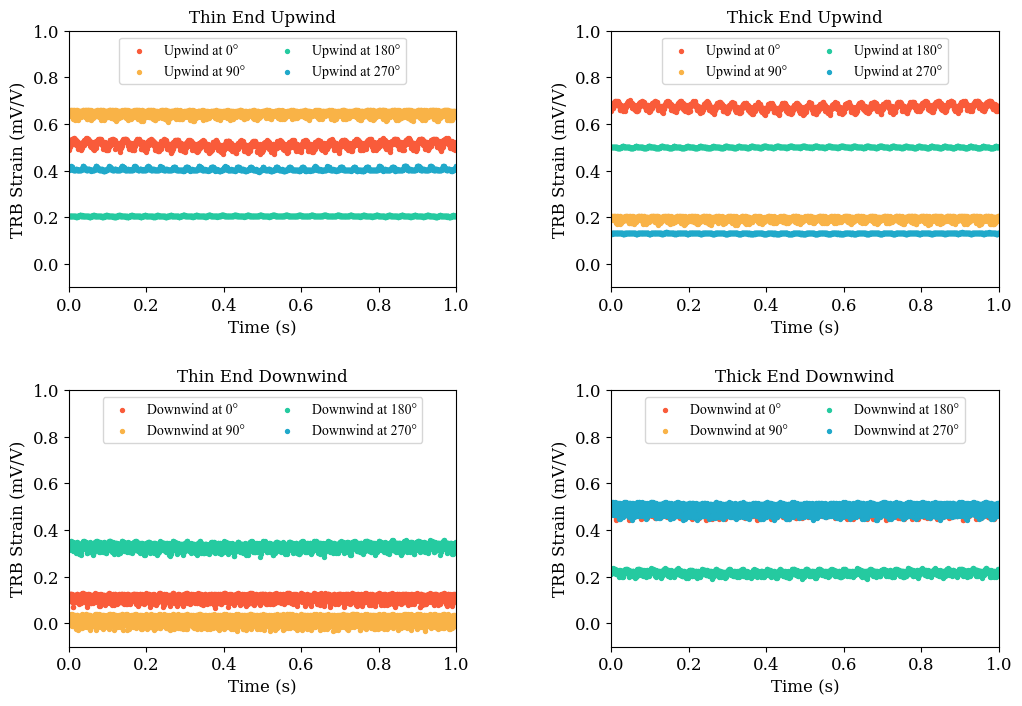

In [6]:
plot_trb(static_ntl_100knm)

 These plots show the time series data of upwind and downwind bearing strains measured at different angles, at "Thin End" and "Thick End" of the high-speed shaft. The strain values appear to be steady over time without significant fluctuations. For 90 & 270 upwind and 180 downwind the strain levels at the "Thin End" are higher than those at the "Thick End", which could indicate that the "Thin End" experiences more stress or deformation under these conditions.

**Dynamic Loading Bearing Strain**

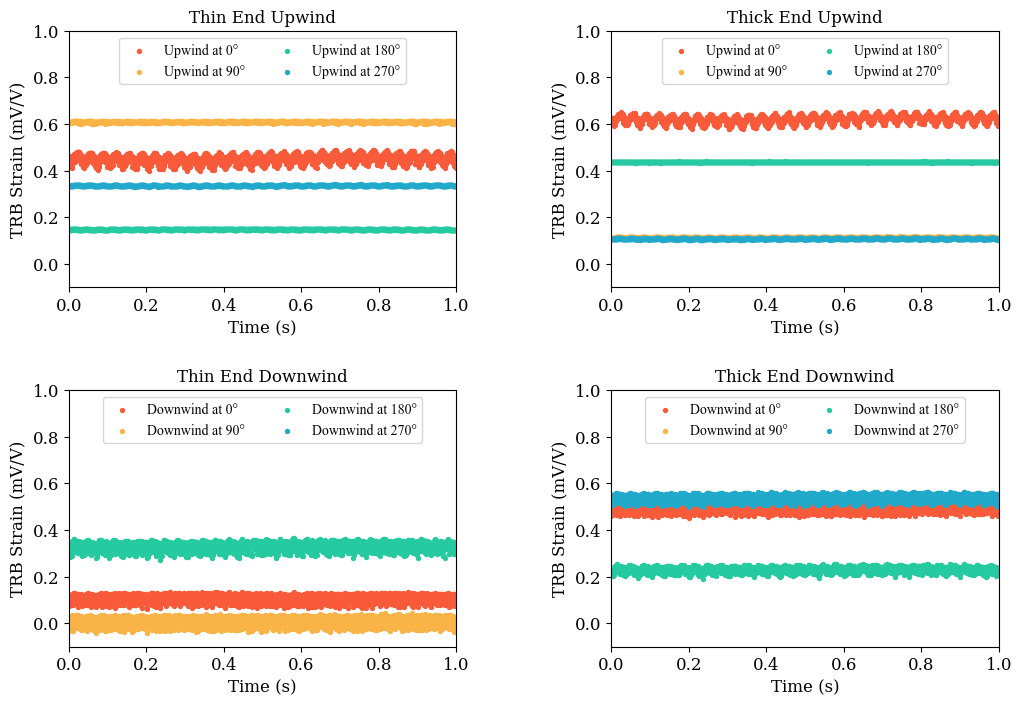

In [7]:
plot_trb(dynamic_ntl_r)

These plots show the time series data of upwind and downwind bearing strains measured at different angles, at "Thin End" and "Thick End" of the high-speed shaft under dynamic loading. Fluctuations in the strain values are slightly more compared to static loading. Here again, at 90 & 270 upwind and 180 downwind the strain levels at the "Thin End" are higher than those at the "Thick End", which could indicate that the "Thin End" experiences more stress or deformation under these conditions.

**LSS Torque Comparison**

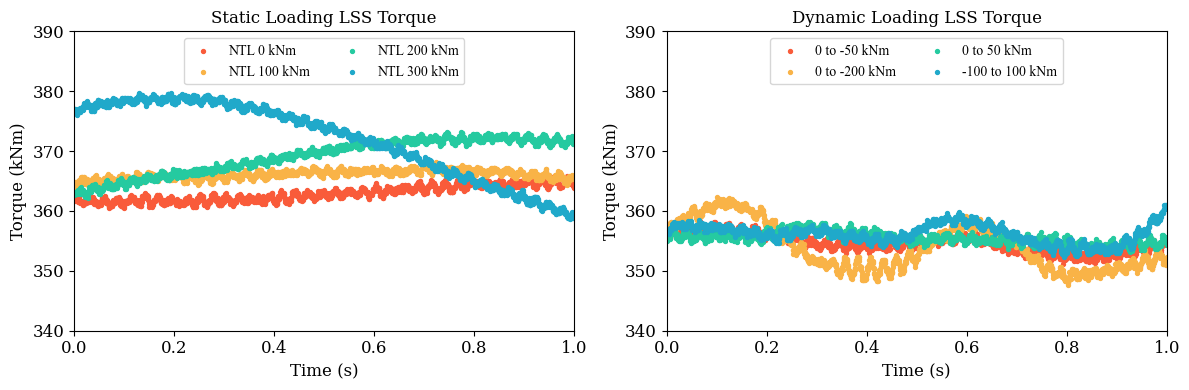

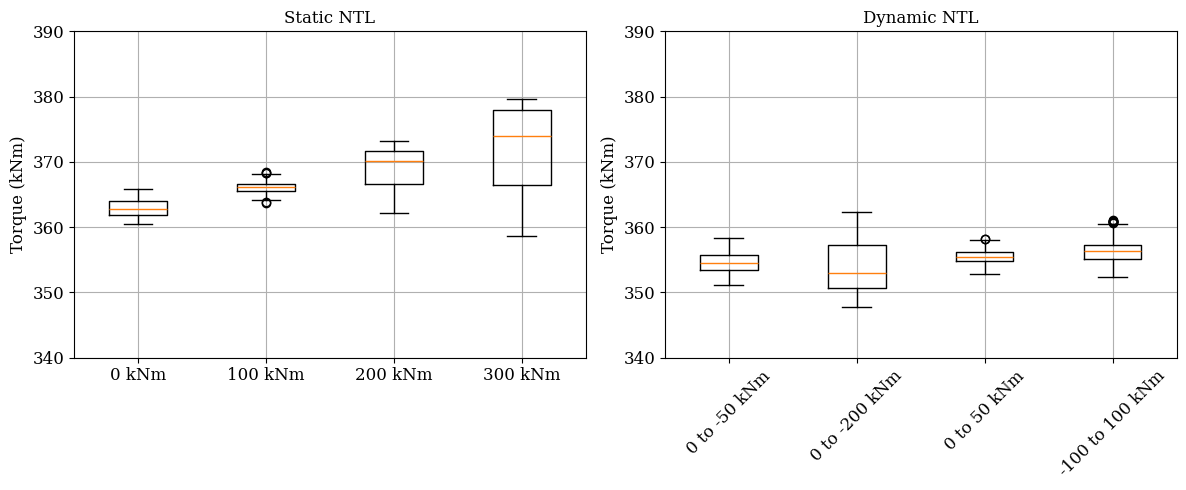

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
plt.rcParams["mathtext.fontset"] = "cm"
hfont = {'fontname':'Times New Roman',
            'family':'serif',
            'size': 12}

def plot_torque(ax, df, title, ylim=None, color='#F95B3A', label=None):
    ax.set_title(title, **hfont)
    ax.scatter(df['LabVIEW Timestamp'] - df['LabVIEW Timestamp'].iloc[0], df['LSS_TQ'], s=8, color=color, label=label)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_xlim([0, 1])
    ax.set_yticklabels(np.array(ax.get_yticks(), dtype=int), **hfont)
    ax.set_xticklabels(np.around(ax.get_xticks(), decimals=1), **hfont)
    ax.set_ylabel('Torque (kNm)', fontdict=hfont, fontsize=12)
    ax.set_xlabel('Time (s)', fontdict=hfont, fontsize=12)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fancybox=True, shadow=False,
                prop={'family': 'Times New Roman', 'size': 10})

plot_torque(axs[0], static_ntl_0knm, "Static Loading LSS Torque", [340, 390], '#F95B3A', 'NTL 0 kNm')
plot_torque(axs[0], static_ntl_100knm, "Static Loading LSS Torque", [340, 390], '#F9B347', 'NTL 100 kNm')
plot_torque(axs[0], static_ntl_200knm, "Static Loading LSS Torque", [340, 390], '#25CAA0', 'NTL 200 kNm')
plot_torque(axs[0], static_ntl_300knm, "Static Loading LSS Torque", [340, 390], '#20A9CA', 'NTL 300 kNm')

plot_torque(axs[1], dynamic_ntl_a, "Dynamic Loading LSS Torque", [340, 390], '#F95B3A', '0 to -50 kNm')
plot_torque(axs[1], dynamic_ntl_d, "Dynamic Loading LSS Torque", [340, 390], '#F9B347', '0 to -200 kNm')
plot_torque(axs[1], dynamic_ntl_g, "Dynamic Loading LSS Torque", [340, 390], '#25CAA0', '0 to 50 kNm')
plot_torque(axs[1], dynamic_ntl_r, "Dynamic Loading LSS Torque", [340, 390], '#20A9CA', '-100 to 100 kNm')

plt.tight_layout()
plt.show()

# Extract torque data for each type of loading
static_torques = [static_ntl_0knm['LSS_TQ'], static_ntl_100knm['LSS_TQ'], static_ntl_200knm['LSS_TQ'], static_ntl_300knm['LSS_TQ']]
dynamic_torques = [dynamic_ntl_a['LSS_TQ'], dynamic_ntl_d['LSS_TQ'], dynamic_ntl_g['LSS_TQ'], dynamic_ntl_r['LSS_TQ']]

# Plot box plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
plt.rcParams["mathtext.fontset"] = "cm"

axs[0].boxplot(static_torques)
axs[0].set_title('Static NTL', fontdict=hfont, fontsize=12)
axs[0].set_xticklabels(['0 kNm', '100 kNm', '200 kNm', '300 kNm'], **hfont)
axs[0].set_yticklabels([340, 350, 360, 370, 380, 390], **hfont)
axs[0].set_ylabel('Torque (kNm)', fontdict=hfont, fontsize=12)
axs[0].set_ylim([340, 390])
axs[0].grid(True)

axs[1].boxplot(dynamic_torques)
axs[1].set_title('Dynamic NTL', fontdict=hfont, fontsize=12)
axs[1].set_xticklabels(['0 to -50 kNm', '0 to -200 kNm', '0 to 50 kNm', '-100 to 100 kNm'], **hfont, rotation=45)
axs[1].set_yticklabels([340, 350, 360, 370, 380, 390], **hfont)
axs[1].set_ylabel('Torque (kNm)', fontdict=hfont, fontsize=12)
axs[1].set_ylim([340, 390])
axs[1].grid(True)

plt.tight_layout()
plt.show()



**First Set of Plots (Time Series Plots):**

Static Loading: This plot shows four time series that represent the torque on the shaft under different static load conditions: 0 kNm, 100 kNm, 200 kNm, and 300 kNm. Each time series corresponds to a different load, showing how the Low-speed Shaft torque varies over time. The torque levels appear to be higher with increasing static load, and there are minor fluctuations around a mean value, which is expected in a static load scenario.

Dynamic Loading: This plot shows four time series under dynamic loading conditions with different ranges of loading: 0 to -50 kNm, 0 to 50 kNm, 0 to -200 kNm, and -100 to 100 kNm. Unlike the static scenario, the dynamic loading shows more variability and fluctuations in torque, indicating the varying nature of dynamic loads.

**Second Set of Plots (Boxplots):**

Static Loading: These boxplots show the distribution of torque values under the same static load conditions as the first plot. Each boxplot corresponds to a different static load (0 kNm, 100 kNm, 200 kNm, 300 kNm). In this case, the spread of the data increases with the load, indicating more variability in the measured torque at higher loads.

Dynamic Loading: Similar to the static loading, these boxplots show the distribution of torque values for different dynamic loading conditions. The spread and median values differ across the different dynamic load ranges, reflecting the complexity of dynamic loading on the torque experienced by the shaft. Few outliers are also observed for 0 to 50 kNm and -100 to 100 kNm loading.

**Total Bending Moment of Low Speed Shaft**

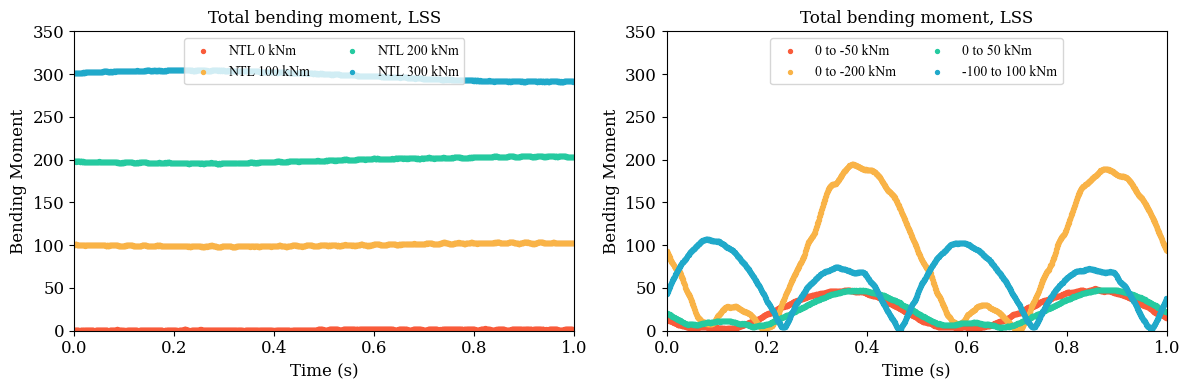

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
plt.rcParams["mathtext.fontset"] = "cm"
hfont = {'fontname':'Times New Roman',
            'family':'serif',
            'size': 12}

def plot_msbm(ax, df, title, ylim=None, color='#F95B3A', label=None):
    ax.set_title(title, **hfont)
    ax.scatter(df['LabVIEW Timestamp'] - df['LabVIEW Timestamp'].iloc[0], df['MSBM'], s=8, color=color, label=label)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_xlim([0, 1])
    ax.set_yticklabels(np.array(ax.get_yticks(), dtype=int), **hfont)
    ax.set_xticklabels(np.around(ax.get_xticks(), decimals=1), **hfont)
    ax.set_ylabel('Bending Moment', fontdict=hfont, fontsize=12)
    ax.set_xlabel('Time (s)', fontdict=hfont, fontsize=12)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fancybox=True, shadow=False,
                prop={'family': 'Times New Roman', 'size': 10})

plot_msbm(axs[0], static_ntl_0knm, "Total bending moment, LSS", [0, 350], '#F95B3A', 'NTL 0 kNm')
plot_msbm(axs[0], static_ntl_100knm, "Total bending moment, LSS", [0, 350], '#F9B347', 'NTL 100 kNm')
plot_msbm(axs[0], static_ntl_200knm, "Total bending moment, LSS", [0, 350], '#25CAA0', 'NTL 200 kNm')
plot_msbm(axs[0], static_ntl_300knm, "Total bending moment, LSS", [0, 350], '#20A9CA', 'NTL 300 kNm')

plot_msbm(axs[1], dynamic_ntl_a, "Total bending moment, LSS", [0, 350], '#F95B3A', '0 to -50 kNm')
plot_msbm(axs[1], dynamic_ntl_d, "Total bending moment, LSS", [0, 350], '#F9B347', '0 to -200 kNm')
plot_msbm(axs[1], dynamic_ntl_g, "Total bending moment, LSS", [0, 350], '#25CAA0', '0 to 50 kNm')
plot_msbm(axs[1], dynamic_ntl_r, "Total bending moment, LSS", [0, 350], '#20A9CA', '-100 to 100 kNm')

plt.tight_layout()
plt.show()


The plots show the total bending moment experienced by the Low-Speed Shaft (LSS) under static and dynamic loading conditions. In the static loading plot, the bending moment values are consistent and do not show any fluctuations, reflecting the constant nature of the applied loads whereas in the dynamic loading plot, the bending moments exhibit peaks and troughs, which represent the cyclical or fluctuating nature of the applied dynamic loads.

**Fast Fourier Transform (FFT) analyses**

Following section shows the FFT analysis of LSS Torque signal in case of static and dynamic loading

**Static Loading**

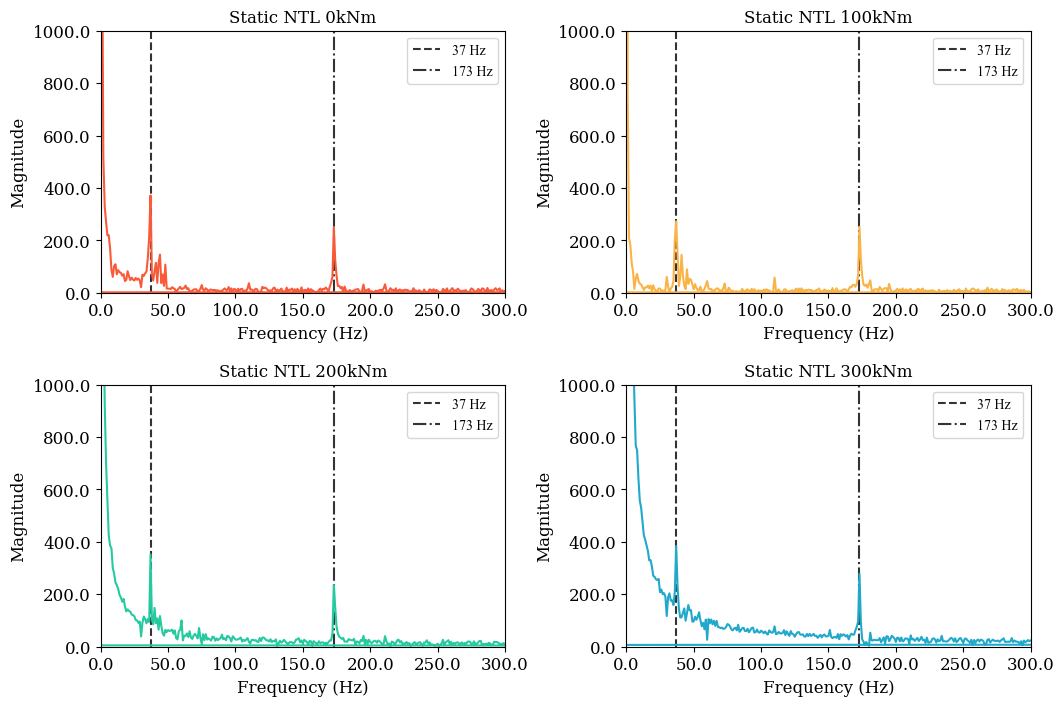

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=100)
plt.rcParams["mathtext.fontset"] = "cm"
colors = ['#F95B3A', '#F9B347', '#25CAA0', '#20A9CA']

axs[0, 0].axvline(x=37, color='#333333', linestyle='--', label='37 Hz')
axs[0, 0].axvline(x=173, color='#333333', linestyle='-.', label='173 Hz')
plot_fft(axs[0, 0], static_ntl_0knm['LSS_TQ'], 'Static NTL 0kNm', colors[0])
axs[0, 0].legend(loc='upper center', bbox_to_anchor=(0.87, 1), ncol=1, fancybox=True, shadow=False, prop={'family': 'Times New Roman', 'size': 10})
axs[0, 1].axvline(x=37, color='#333333', linestyle='--', label='37 Hz')
axs[0, 1].axvline(x=173, color='#333333', linestyle='-.', label='173 Hz')
plot_fft(axs[0, 1], static_ntl_100knm['LSS_TQ'], 'Static NTL 100kNm', colors[1])
axs[0, 1].legend(loc='upper center', bbox_to_anchor=(0.87, 1), ncol=1, fancybox=True, shadow=False, prop={'family': 'Times New Roman', 'size': 10})
axs[1, 0].axvline(x=37, color='#333333', linestyle='--', label='37 Hz')
axs[1, 0].axvline(x=173, color='#333333', linestyle='-.', label='173 Hz')
plot_fft(axs[1, 0], static_ntl_200knm['LSS_TQ'], 'Static NTL 200kNm', colors[2])
axs[1, 0].legend(loc='upper center', bbox_to_anchor=(0.87, 1), ncol=1, fancybox=True, shadow=False, prop={'family': 'Times New Roman', 'size': 10})
axs[1, 1].axvline(x=37, color='#333333', linestyle='--', label='37 Hz')
axs[1, 1].axvline(x=173, color='#333333', linestyle='-.', label='173 Hz')
plot_fft(axs[1, 1], static_ntl_300knm['LSS_TQ'], 'Static NTL 300kNm', colors[3])
axs[1, 1].legend(loc='upper center', bbox_to_anchor=(0.87, 1), ncol=1, fancybox=True, shadow=False, prop={'family': 'Times New Roman', 'size': 10})

plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()

These plots show the FFT analyses of torque for various static load conditions. The prominent peaks represent the fundamental frequencies of the torque signal and their harmonics. There are prominent peaks at 37 Hz and 173 Hz for all the loads which could be due to the system's natural vibration or background noise as they appear at 0 kNm also. The magnitude of the frequency components seems to change with the load. This could be due to the changing stiffness and damping properties of the shaft as the load varies.


**Dynamic Loading**

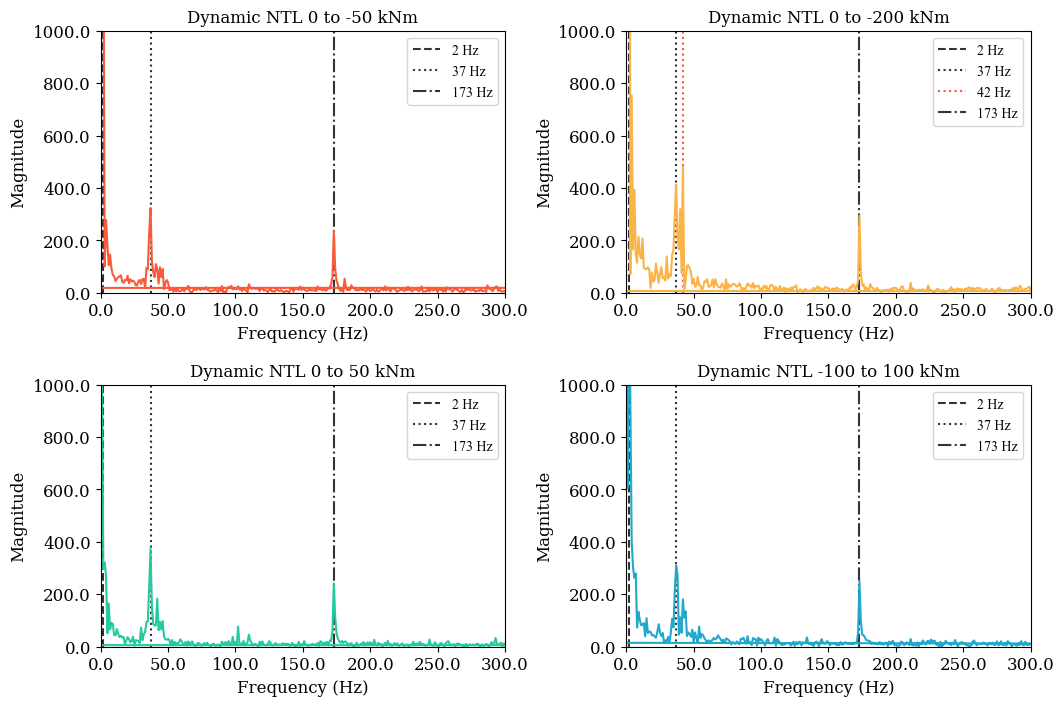

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=100)
plt.rcParams["mathtext.fontset"] = "cm"
colors = ['#F95B3A', '#F9B347', '#25CAA0', '#20A9CA']

axs[0, 0].axvline(x=2, color='#333333', linestyle='--', label='2 Hz')
axs[0, 0].axvline(x=37, color='#333333', linestyle=':', label='37 Hz')
axs[0, 0].axvline(x=173, color='#333333', linestyle='-.', label='173 Hz')
plot_fft(axs[0, 0], dynamic_ntl_a['LSS_TQ'], 'Dynamic NTL 0 to -50 kNm', colors[0])
axs[0, 0].legend(loc='upper center', bbox_to_anchor=(0.87, 1), ncol=1, fancybox=True, shadow=False, prop={'family': 'Times New Roman', 'size': 10})
axs[0, 1].axvline(x=2, color='#333333', linestyle='--', label='2 Hz')
axs[0, 1].axvline(x=37, color='#333333', linestyle=':', label='37 Hz')
axs[0, 1].axvline(x=42, color='#F95B3A', linestyle=':', label='42 Hz')
axs[0, 1].axvline(x=173, color='#333333', linestyle='-.', label='173 Hz')
plot_fft(axs[0, 1], dynamic_ntl_d['LSS_TQ'], 'Dynamic NTL 0 to -200 kNm', colors[1])
axs[0, 1].legend(loc='upper center', bbox_to_anchor=(0.87, 1), ncol=1, fancybox=True, shadow=False, prop={'family': 'Times New Roman', 'size': 10})
axs[1, 0].axvline(x=2, color='#333333', linestyle='--', label='2 Hz')
axs[1, 0].axvline(x=37, color='#333333', linestyle=':', label='37 Hz')
axs[1, 0].axvline(x=173, color='#333333', linestyle='-.', label='173 Hz')
plot_fft(axs[1, 0], dynamic_ntl_g['LSS_TQ'], 'Dynamic NTL 0 to 50 kNm', colors[2])
axs[1, 0].legend(loc='upper center', bbox_to_anchor=(0.87, 1), ncol=1, fancybox=True, shadow=False, prop={'family': 'Times New Roman', 'size': 10})
axs[1, 1].axvline(x=2, color='#333333', linestyle='--', label='2 Hz')
axs[1, 1].axvline(x=37, color='#333333', linestyle=':', label='37 Hz')
axs[1, 1].axvline(x=173, color='#333333', linestyle='-.', label='173 Hz')
plot_fft(axs[1, 1], dynamic_ntl_r['LSS_TQ'], 'Dynamic NTL -100 to 100 kNm', colors[3])
axs[1, 1].legend(loc='upper center', bbox_to_anchor=(0.87, 1), ncol=1, fancybox=True, shadow=False, prop={'family': 'Times New Roman', 'size': 10})

plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()

These plots show FFT analyses of torque under different dynamic loading conditions. There are prominent peaks at 2, 37 and 173 Hz in all the loading conditions. 2Hz peak is due to the frequency of load application and 37Hz and 173Hz are probably due to the system's natural vibration or background noise. In  0 to -200 kNm plot we see another peak appearing at 42 Hz. 0 to -200 kNm plot also show a higher magnitude at lower frequencies, which may indicate that higher negative loads induce stronger low-frequency components in the torque signal.

**Statistics of the torque distribution**

Static Test Statistics:

Standard Deviation: 2.9353175335846116
Skewness: -0.5593141468239439
Kurtosis: -1.0155360011362966

Dynamic Test Statistics:

Standard Deviation: 1.5707925811613177
Skewness: -0.09876737416191982
Kurtosis: -0.3352631211348127


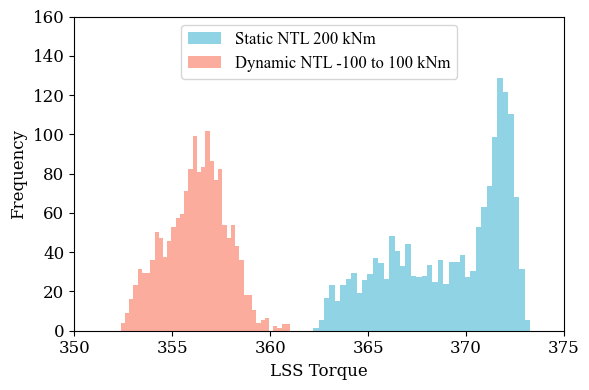

In [12]:
# Load static test data
static_df = static_ntl_200knm.copy()

# Load dynamic test data 
dynamic_df = dynamic_ntl_r.copy()

# Calculate statistics
static_std = static_df['LSS_TQ'].std() 
static_skew = static_df['LSS_TQ'].skew()
static_kurtosis = static_df['LSS_TQ'].kurtosis()

print("Static Test Statistics:\n")
print("Standard Deviation:", static_std)
print("Skewness:", static_skew)
print("Kurtosis:", static_kurtosis)

dynamic_std = dynamic_df['LSS_TQ'].std()
dynamic_skew = dynamic_df['LSS_TQ'].skew() 
dynamic_kurtosis = dynamic_df['LSS_TQ'].kurtosis()

print("\nDynamic Test Statistics:\n") 
print("Standard Deviation:", dynamic_std)
print("Skewness:", dynamic_skew)
print("Kurtosis:", dynamic_kurtosis)


fig = plt.figure(figsize=(6, 4), dpi=100)
axs = fig.add_subplot(111)
axs.hist(static_df['LSS_TQ'], bins=40, alpha=0.5, color='#20A9CA', label="Static NTL 200 kNm")
axs.hist(dynamic_df['LSS_TQ'], bins=40, alpha=0.5, color='#F95B3A', label="Dynamic NTL -100 to 100 kNm")
axs.set_xticklabels(axs.get_xticklabels(), **hfont)
axs.set_yticklabels(axs.get_yticklabels(), **hfont)
axs.set_xlabel('LSS Torque', **hfont)
axs.set_ylabel('Frequency', **hfont)
axs.set_xlim([350, 375])
axs.set_ylim([0, 200])
axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=1, fancybox=True, shadow=False, prop={'family': 'Times New Roman', 'size': 12})


plt.tight_layout()
plt.show()


This plot show the statistics of the torque distribution under static and dynamic loading. For static loading, test with NTL of 200kNm is selected and for dynamic loading, test with NTL of -100 to 100 kNm was used. A standard deviation of 2.93 was observed for static loading case and a standard deviation of 1.57 was observed for dynamic loading case, suggesting that for dynamic loading the torque values are more consistently clustered around the mean and there is less spread. The dynamic test has a skewness closer to zero (-0.09), indicating a more symmetric distribution of data around the mean. The negative value in both static and dynamic cases suggests a tail to the left. Both distribution have negative kurtosis, however static case has a higher value which indicates a flatter distribution compared to dynamic case.

---

## Effect of power loading

Following lines load the static loading (100kNm), dynamic loading (-100 to 100kNm) and static thrust (100kN) datasets at different power levels

In [13]:
static_ntl_100knm_0power = read_tdms(r"Data/5.2.1 Static NTL 0 Power 1800 RPM/0% Power 1800 RPM/FastData/Static_NTL_3A_100kNm_2014_11_19_16_04_24_2000Hz.tdms")
static_ntl_100knm_25power = read_tdms(r"Data/5.2.1 Static NTL 25 Power/25% Power/FastData/Static_NTL_4A_100kNm_2014_11_11_15_39_36_2000Hz.tdms")
static_ntl_100knm_50power = read_tdms(r"Data/5.2.1 Static NTL 50 Power/50% Power/FastData/Static_NTL_5A_100kNm_2014_11_13_14_50_35_2000Hz.tdms")
static_ntl_100knm_75power = read_tdms(r"Data/5.2.1 Static NTL 75 Power/75% Power/FastData/Static_NTL_6A_100kNm_2014_11_19_13_29_48_2000Hz.tdms")
static_ntl_100knm_100power = read_tdms(r"Data/5.2.1 Static NTL 100 Power/100% Power/FastData/Static_NTL_7A_100kNm_2014_11_12_09_39_49_2000Hz.tdms")


dynamic_ntl_r_0power = read_tdms(r"Data/5.2.2 Dynamic NTL/FastData/Dynamic_NTL_1R_2014_03_18_10_58_02_2000Hz.tdms")
dynamic_ntl_r_25power = read_tdms(r"Data/5.2.2 Dynamic NTL/FastData/Dynamic_NTL_2R_2014_03_18_11_24_03_2000Hz.tdms")
dynamic_ntl_r_100power = read_tdms(r"Data/5.2.2 Dynamic NTL/FastData/Dynamic_NTL_3R_2014_03_18_11_55_53_2000Hz.tdms")


static_thrust_100kN_0power = read_tdms(r"Data/5.2.3 Static Thrust/FastData/Static_Fx_1_100kN_2014_03_18_15_27_36_2000Hz.tdms")
static_thrust_100kN_25power = read_tdms(r"Data/5.2.3 Static Thrust/FastData/Static_Fx_3_100kN_2014_03_18_16_44_57_2000Hz.tdms")
static_thrust_100kN_50power = read_tdms(r"Data/5.2.3 Static Thrust/FastData/Static_Fx_4_100kN_2014_03_18_17_00_23_2000Hz.tdms")
static_thrust_100kN_75power = read_tdms(r"Data/5.2.3 Static Thrust/FastData/Static_Fx_5_100kN_2014_03_18_17_17_57_2000Hz.tdms")
static_thrust_100kN_100power = read_tdms(r"Data/5.2.3 Static Thrust/FastData/Static_Fx_6_100kN_2014_03_18_17_34_22_2000Hz.tdms")


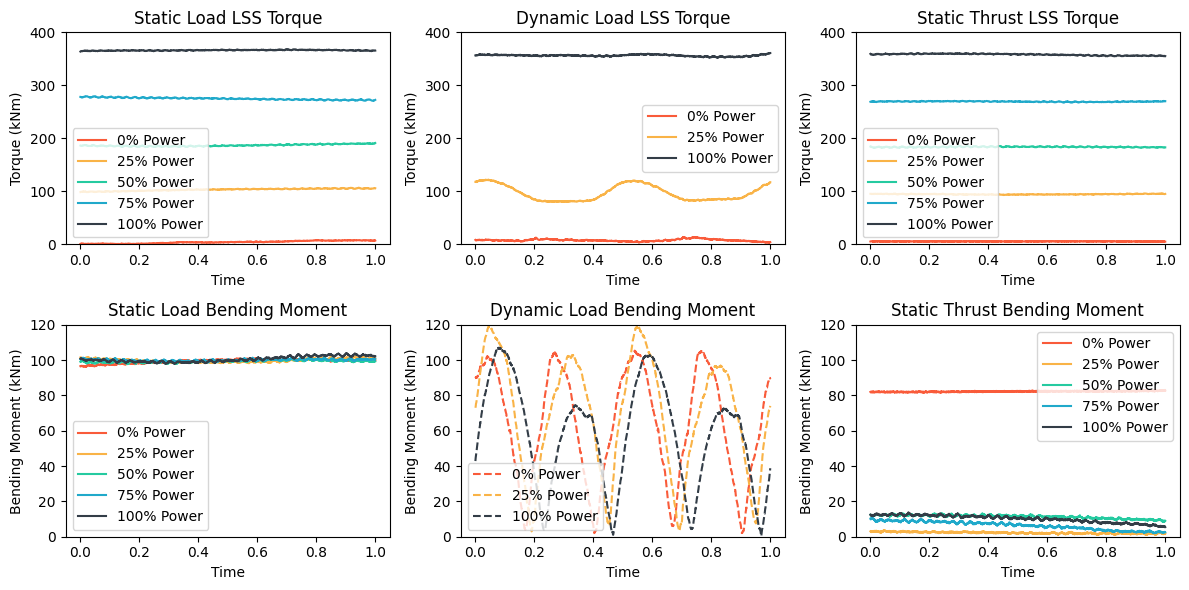

In [14]:
# Create subplots for static and dynamic plots
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
colors = ['#F95B3A', '#F9B347', '#25CAA0', '#20A9CA', '#333d47']
# Plot static load data
axs[0, 0].plot(static_ntl_100knm_0power['LabVIEW Timestamp'] - static_ntl_100knm_0power['LabVIEW Timestamp'].iloc[0], static_ntl_100knm_0power["LSS_TQ"], 
            label='0% Power', color=colors[0])
axs[0, 0].plot(static_ntl_100knm_25power['LabVIEW Timestamp'] - static_ntl_100knm_25power['LabVIEW Timestamp'].iloc[0], static_ntl_100knm_25power["LSS_TQ"], 
            label='25% Power', color=colors[1])
axs[0, 0].plot(static_ntl_100knm_50power['LabVIEW Timestamp'] - static_ntl_100knm_50power['LabVIEW Timestamp'].iloc[0], static_ntl_100knm_50power["LSS_TQ"], 
            label='50% Power', color=colors[2])
axs[0, 0].plot(static_ntl_100knm_75power['LabVIEW Timestamp'] - static_ntl_100knm_75power['LabVIEW Timestamp'].iloc[0], static_ntl_100knm_75power["LSS_TQ"], 
            label='75% Power', color=colors[3])
axs[0, 0].plot(static_ntl_100knm_100power['LabVIEW Timestamp'] - static_ntl_100knm_100power['LabVIEW Timestamp'].iloc[0], static_ntl_100knm_100power["LSS_TQ"], 
            label='100% Power', color=colors[4])

axs[0, 0].set_title('Static Load LSS Torque')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Torque (kNm)')
axs[0, 0].set_ylim([0,400])
axs[0, 0].legend()

# Plot dynamic load data
axs[0, 1].plot(dynamic_ntl_r_0power['LabVIEW Timestamp'] - dynamic_ntl_r_0power['LabVIEW Timestamp'].iloc[0], dynamic_ntl_r_0power["LSS_TQ"], 
            label='0% Power', linestyle='-', color=colors[0])
axs[0, 1].plot(dynamic_ntl_r_25power['LabVIEW Timestamp'] - dynamic_ntl_r_25power['LabVIEW Timestamp'].iloc[0], dynamic_ntl_r_25power["LSS_TQ"], 
            label='25% Power', linestyle='-', color=colors[1])
axs[0, 1].plot(dynamic_ntl_r_100power['LabVIEW Timestamp'] - dynamic_ntl_r_100power['LabVIEW Timestamp'].iloc[0], dynamic_ntl_r_100power["LSS_TQ"], 
            label='100% Power', linestyle='-', color=colors[4])

axs[0, 1].set_title('Dynamic Load LSS Torque')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Torque (kNm)')
axs[0, 1].set_ylim([0,400])
axs[0, 1].legend()

# Plot static thrust data
axs[0, 2].plot(static_thrust_100kN_0power['LabVIEW Timestamp'] - static_thrust_100kN_0power['LabVIEW Timestamp'].iloc[0], static_thrust_100kN_0power["LSS_TQ"], 
            label='0% Power', color=colors[0])
axs[0, 2].plot(static_thrust_100kN_25power['LabVIEW Timestamp'] - static_thrust_100kN_25power['LabVIEW Timestamp'].iloc[0], static_thrust_100kN_25power["LSS_TQ"], 
            label='25% Power', color=colors[1])
axs[0, 2].plot(static_thrust_100kN_50power['LabVIEW Timestamp'] - static_thrust_100kN_50power['LabVIEW Timestamp'].iloc[0], static_thrust_100kN_50power["LSS_TQ"], 
            label='50% Power', color=colors[2])
axs[0, 2].plot(static_thrust_100kN_75power['LabVIEW Timestamp'] - static_thrust_100kN_75power['LabVIEW Timestamp'].iloc[0], static_thrust_100kN_75power["LSS_TQ"], 
            label='75% Power', color=colors[3])
axs[0, 2].plot(static_thrust_100kN_100power['LabVIEW Timestamp'] - static_thrust_100kN_100power['LabVIEW Timestamp'].iloc[0], static_thrust_100kN_100power["LSS_TQ"], 
            label='100% Power', color=colors[4])

axs[0, 2].set_title('Static Thrust LSS Torque')
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('Torque (kNm)')
axs[0, 2].set_ylim([0,400])
axs[0, 2].legend()


# Plot static load data
axs[1, 0].plot(static_ntl_100knm_0power['LabVIEW Timestamp'] - static_ntl_100knm_0power['LabVIEW Timestamp'].iloc[0], static_ntl_100knm_0power["MSBM"], 
            label='0% Power', color=colors[0])
axs[1, 0].plot(static_ntl_100knm_25power['LabVIEW Timestamp'] - static_ntl_100knm_25power['LabVIEW Timestamp'].iloc[0], static_ntl_100knm_25power["MSBM"], 
            label='25% Power', color=colors[1])
axs[1, 0].plot(static_ntl_100knm_50power['LabVIEW Timestamp'] - static_ntl_100knm_50power['LabVIEW Timestamp'].iloc[0], static_ntl_100knm_50power["MSBM"], 
            label='50% Power', color=colors[2])
axs[1, 0].plot(static_ntl_100knm_75power['LabVIEW Timestamp'] - static_ntl_100knm_75power['LabVIEW Timestamp'].iloc[0], static_ntl_100knm_75power["MSBM"], 
            label='75% Power', color=colors[3])
axs[1, 0].plot(static_ntl_100knm_100power['LabVIEW Timestamp'] - static_ntl_100knm_100power['LabVIEW Timestamp'].iloc[0], static_ntl_100knm_100power["MSBM"], 
            label='100% Power', color=colors[4])

axs[1, 0].set_title('Static Load Bending Moment')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Bending Moment (kNm)')
axs[1, 0].set_ylim([0,120])
axs[1, 0].legend()

# Plot dynamic load data
axs[1, 1].plot(dynamic_ntl_r_0power['LabVIEW Timestamp'] - dynamic_ntl_r_0power['LabVIEW Timestamp'].iloc[0], dynamic_ntl_r_0power["MSBM"], 
            label='0% Power', linestyle='--', color=colors[0])
axs[1, 1].plot(dynamic_ntl_r_25power['LabVIEW Timestamp'] - dynamic_ntl_r_25power['LabVIEW Timestamp'].iloc[0], dynamic_ntl_r_25power["MSBM"], 
            label='25% Power', linestyle='--', color=colors[1])
axs[1, 1].plot(dynamic_ntl_r_100power['LabVIEW Timestamp'] - dynamic_ntl_r_100power['LabVIEW Timestamp'].iloc[0], dynamic_ntl_r_100power["MSBM"], 
            label='100% Power', linestyle='--', color=colors[4])

axs[1, 1].set_title('Dynamic Load Bending Moment')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Bending Moment (kNm)')
axs[1, 1].set_ylim([0,120])
axs[1, 1].legend()

# Plot static thrust data
axs[1, 2].plot(static_thrust_100kN_0power['LabVIEW Timestamp'] - static_thrust_100kN_0power['LabVIEW Timestamp'].iloc[0], static_thrust_100kN_0power["MSBM"], 
            label='0% Power', color=colors[0])
axs[1, 2].plot(static_thrust_100kN_25power['LabVIEW Timestamp'] - static_thrust_100kN_25power['LabVIEW Timestamp'].iloc[0], static_thrust_100kN_25power["MSBM"], 
            label='25% Power', color=colors[1])
axs[1, 2].plot(static_thrust_100kN_50power['LabVIEW Timestamp'] - static_thrust_100kN_50power['LabVIEW Timestamp'].iloc[0], static_thrust_100kN_50power["MSBM"], 
            label='50% Power', color=colors[2])
axs[1, 2].plot(static_thrust_100kN_75power['LabVIEW Timestamp'] - static_thrust_100kN_75power['LabVIEW Timestamp'].iloc[0], static_thrust_100kN_75power["MSBM"], 
            label='75% Power', color=colors[3])
axs[1, 2].plot(static_thrust_100kN_100power['LabVIEW Timestamp'] - static_thrust_100kN_100power['LabVIEW Timestamp'].iloc[0], static_thrust_100kN_100power["MSBM"], 
            label='100% Power', color=colors[4])

axs[1, 2].set_title('Static Thrust Bending Moment')
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('Bending Moment (kNm)')
axs[1, 2].set_ylim([0,120])
axs[1, 2].legend()


plt.tight_layout()
plt.show()


These plots illustrate the effects of power loading in cases of static loading, dynamic loading, and static thrust. For the static loading case, a load of 100 kNm was chosen. For the dynamic loading case, a load range from -100 to 100 kNm was selected, and for the static thrust case, a load of 100 kN was selected.

**Static load torque:**
The torque values are constant over time, as expected under static conditions, and increase with the power level.

**Dynamic load LSS torque:**
Unlike the static case, the dynamic load shows variability over time, particularly noticeable at 25% power. At 0% and 100% power, the torque remains relatively constant, similar to the static condition.

**Static thrust LSS torque:**
The torque values are constant over time, as expected under static conditions, and increase with the power level.

**Static load Bending Moment:**
Bending moment is stable across different power outputs, which is typical under static conditions.

**Dynamic load Bending Moment:**
There are pronounced fluctuations over time, especially at 25% power. This variability indicates that the bending moment changes significantly during operation, which can be due to varying loads or operational conditions affecting the gearbox.

**Static thrust Bending Moment:**
The bending moment values here are also stable over time.


---

## Effect of generator misalignment

Following lines of code load all the 2000Hz generator misalignment files

In [15]:
misalign_0deg_0power = read_tdms(r"Data/5.3 Generator Misalignment/0 Degree/No Tare/Misalignment_0_0P_2014_12_30_11_44_08_2000Hz.tdms")
misalign_0deg_25power = read_tdms(r"Data/5.3 Generator Misalignment/0 Degree/No Tare/Misalignment_0_25P_2014_12_30_11_28_14_2000Hz.tdms")
misalign_0deg_50power = read_tdms(r"Data/5.3 Generator Misalignment/0 Degree/No Tare/Misalignment_0_50P_2014_12_30_11_31_09_2000Hz.tdms")
misalign_0deg_75power = read_tdms(r"Data/5.3 Generator Misalignment/0 Degree/No Tare/Misalignment_0_75P_2014_12_30_11_35_46_2000Hz.tdms")
misalign_0deg_100power = read_tdms(r"Data/5.3 Generator Misalignment/0 Degree/No Tare/Misalignment_0_100P_2014_12_30_11_40_00_2000Hz.tdms")

misalign_0p5deg_0power = read_tdms(r"Data/5.3 Generator Misalignment/0.5 Degree/No Tare/Misalignment_0P5_0P_2014_12_22_10_37_37_2000Hz.tdms")
misalign_0p5deg_25power = read_tdms(r"Data/5.3 Generator Misalignment/0.5 Degree/No Tare/Misalignment_0P5_25P_2014_12_22_09_59_15_2000Hz.tdms")
misalign_0p5deg_50power = read_tdms(r"Data/5.3 Generator Misalignment/0.5 Degree/No Tare/Misalignment_0P5_50P_2014_12_22_10_01_15_2000Hz.tdms")
misalign_0p5deg_75power = read_tdms(r"Data/5.3 Generator Misalignment/0.5 Degree/No Tare/Misalignment_0P5_75P_2014_12_22_10_05_02_2000Hz.tdms")
misalign_0p5deg_100power = read_tdms(r"Data/5.3 Generator Misalignment/0.5 Degree/No Tare/Misalignment_0P5_100P_2014_12_22_10_06_53_2000Hz.tdms")

misalign_1deg_0power = read_tdms(r"Data/5.3 Generator Misalignment/1.0 Degree/No Tare/Misalignment_1_0P_2014_12_16_14_23_36_2000Hz.tdms")
misalign_1deg_25power = read_tdms(r"Data/5.3 Generator Misalignment/1.0 Degree/No Tare/Misalignment_1_25P_2014_12_16_14_17_34_2000Hz.tdms")
misalign_1deg_50power = read_tdms(r"Data/5.3 Generator Misalignment/1.0 Degree/No Tare/Misalignment_1_50P_2014_12_16_14_19_16_2000Hz.tdms")
misalign_1deg_75power = read_tdms(r"Data/5.3 Generator Misalignment/1.0 Degree/No Tare/Misalignment_1_75P_2014_12_16_14_20_36_2000Hz.tdms")
misalign_1deg_100power = read_tdms(r"Data/5.3 Generator Misalignment/1.0 Degree/No Tare/Misalignment_1_100P_2014_12_16_14_21_49_2000Hz.tdms")

misalign_2deg_0power = read_tdms(r"Data/5.3 Generator Misalignment/2.0 Degree/No Tare/Misalignment_2_0P_2014_12_16_12_14_35_2000Hz.tdms")
misalign_2deg_25power = read_tdms(r"Data/5.3 Generator Misalignment/2.0 Degree/No Tare/Misalignment_2_25P_2014_12_16_11_53_38_2000Hz.tdms")
misalign_2deg_50power = read_tdms(r"Data/5.3 Generator Misalignment/2.0 Degree/No Tare/Misalignment_2_50P_2014_12_16_11_55_13_2000Hz.tdms")
misalign_2deg_75power = read_tdms(r"Data/5.3 Generator Misalignment/2.0 Degree/No Tare/Misalignment_2_75P_2014_12_16_11_56_39_2000Hz.tdms")
misalign_2deg_100power = read_tdms(r"Data/5.3 Generator Misalignment/2.0 Degree/No Tare/Misalignment_2_100P_2014_12_16_11_58_12_2000Hz.tdms")

misalign_3deg_0power = read_tdms(r"Data/5.3 Generator Misalignment/3.0 Degree/No Tare/Misalignment_3_0P_2014_12_03_09_33_40_2000Hz.tdms")
misalign_3deg_25power = read_tdms(r"Data/5.3 Generator Misalignment/3.0 Degree/No Tare/Misalignment_3_25P_2014_12_03_09_24_29_2000Hz.tdms")
misalign_3deg_50power = read_tdms(r"Data/5.3 Generator Misalignment/3.0 Degree/No Tare/Misalignment_3_50P_2014_12_03_09_26_40_2000Hz.tdms")
misalign_3deg_75power = read_tdms(r"Data/5.3 Generator Misalignment/3.0 Degree/No Tare/Misalignment_3_75P_2014_12_03_09_28_53_2000Hz.tdms")
misalign_3deg_100power = read_tdms(r"Data/5.3 Generator Misalignment/3.0 Degree/No Tare/Misalignment_3_100P_2014_12_03_09_31_28_2000Hz.tdms")

Following code calculates the mean bending moment for different misalignment angles and different power levels

In [16]:
# Function to calculate the average bending moment magnitude
# Since the HSS_exY_BM and HSS_exZ_BM signals are in raw form without sensitivity of the sensor, amplitude of the signal is calculated for average bending moment

def bending_moment(df):
    a_squared = df["HSS_exY_BM"] ** 2
    b_squared = df["HSS_exZ_BM"] ** 2
    return np.max(np.abs(np.sqrt(a_squared + b_squared))) 


# Mean bending moment for each degree of misalignment
mean_0deg = [bending_moment(misalign_0deg_0power), bending_moment(misalign_0deg_25power), bending_moment(misalign_0deg_50power),
                bending_moment(misalign_0deg_75power), bending_moment(misalign_0deg_100power)]
mean_0_5deg = [bending_moment(misalign_0p5deg_0power), bending_moment(misalign_0p5deg_25power), bending_moment(misalign_0p5deg_50power),
                bending_moment(misalign_0p5deg_75power), bending_moment(misalign_0p5deg_100power)]
mean_1deg = [bending_moment(misalign_1deg_0power), bending_moment(misalign_1deg_25power), bending_moment(misalign_1deg_50power),
                bending_moment(misalign_1deg_75power), bending_moment(misalign_1deg_100power)]
mean_2deg = [bending_moment(misalign_2deg_0power), bending_moment(misalign_2deg_25power), bending_moment(misalign_2deg_50power), 
                bending_moment(misalign_2deg_75power), bending_moment(misalign_2deg_100power)]
mean_3deg = [bending_moment(misalign_3deg_0power), bending_moment(misalign_3deg_25power), bending_moment(misalign_3deg_50power), 
                bending_moment(misalign_3deg_75power), bending_moment(misalign_3deg_100power)]

# Create 2D arrays
mean_2d = np.array([mean_0deg, mean_0_5deg, mean_1deg, mean_2deg, mean_3deg])


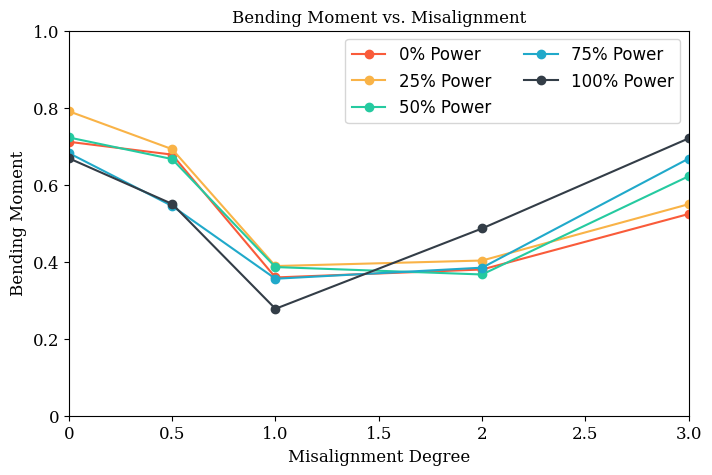

In [17]:
misalignment_degrees = [0,0.5,1,2,3]
# Plot the average bending moments for each power level
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
plt.rcParams["mathtext.fontset"] = "cm"

ax.plot(misalignment_degrees, mean_2d[:,0], marker="o", label="0% Power", color=colors[0])
ax.plot(misalignment_degrees, mean_2d[:,1], marker="o", label="25% Power", color=colors[1])
ax.plot(misalignment_degrees, mean_2d[:,2], marker="o", label="50% Power", color=colors[2])
ax.plot(misalignment_degrees, mean_2d[:,3], marker="o", label="75% Power", color=colors[3])
ax.plot(misalignment_degrees, mean_2d[:,4], marker="o", label="100% Power", color=colors[4])

ax.set_xlim([0, 3])
ax.set_ylim([0.95, 1.05])
ax.set_xticklabels(['0', '0.5', '1.0', '1.5', '2', '2.5', '3.0'], **hfont)
ax.set_yticks([0.95, 0.97, 0.99, 1.01, 1.03, 1.05])
ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'], **hfont)
ax.set_title("Bending Moment vs. Misalignment", **hfont)
ax.set_xlabel("Misalignment Degree", **hfont)
ax.set_ylabel("Bending Moment", **hfont)
ax.legend(ncols=2, prop={'size': 12})

plt.show()

This line graph depict the relationship between bending moment and generator misalignment under various power conditions (0%, 25%, 50%, 75%, and 100%). The bending moment varies with the degree of misalignment and is substantially reduced by introducing a misalignment of 1 or 2 degrees.

---

## Anomalies are detected during the timeseries

Based on the Interquartile Range (IQR), outliers were detected in the LSS Torque values for the static NTL data for 100kNm loading, the dynamic NTL data for 0 to 50kNm loading, and -100 to 100kNm loading. The following code identifies these outliers and prints their count. Outliers, representing data points significantly deviating from the rest of the data, can be considered anomalies.

In [18]:
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers

# Find outliers for each series
outliers_dynamic_ntl_g = find_outliers(dynamic_ntl_g['LSS_TQ'])
outliers_dynamic_ntl_r = find_outliers(dynamic_ntl_r['LSS_TQ'])
outliers_static_ntl_100knm = find_outliers(static_ntl_100knm['LSS_TQ'])

# Display the outliers
print("Number of outliers in LSS Torque values in Dynamic loading (0 to 50kNm) data:", len(outliers_dynamic_ntl_g))
print("\nNumber of outliers in LSS Torque values Dynamic loading of (-100 to 100kNm) data:", len(outliers_dynamic_ntl_r))
print("\nNumber of outliers in LSS Torque values Static loading (100kNm) data:", len(outliers_static_ntl_100knm))

Number of outliers in LSS Torque values in Dynamic loading (0 to 50kNm) data: 2

Number of outliers in LSS Torque values Dynamic loading of (-100 to 100kNm) data: 8

Number of outliers in LSS Torque values Static loading (100kNm) data: 5


---

## Is time series forecasting possible?

The following code loads 100Hz data for one case of static loading to analyse if time series forecasting is possible or not. 

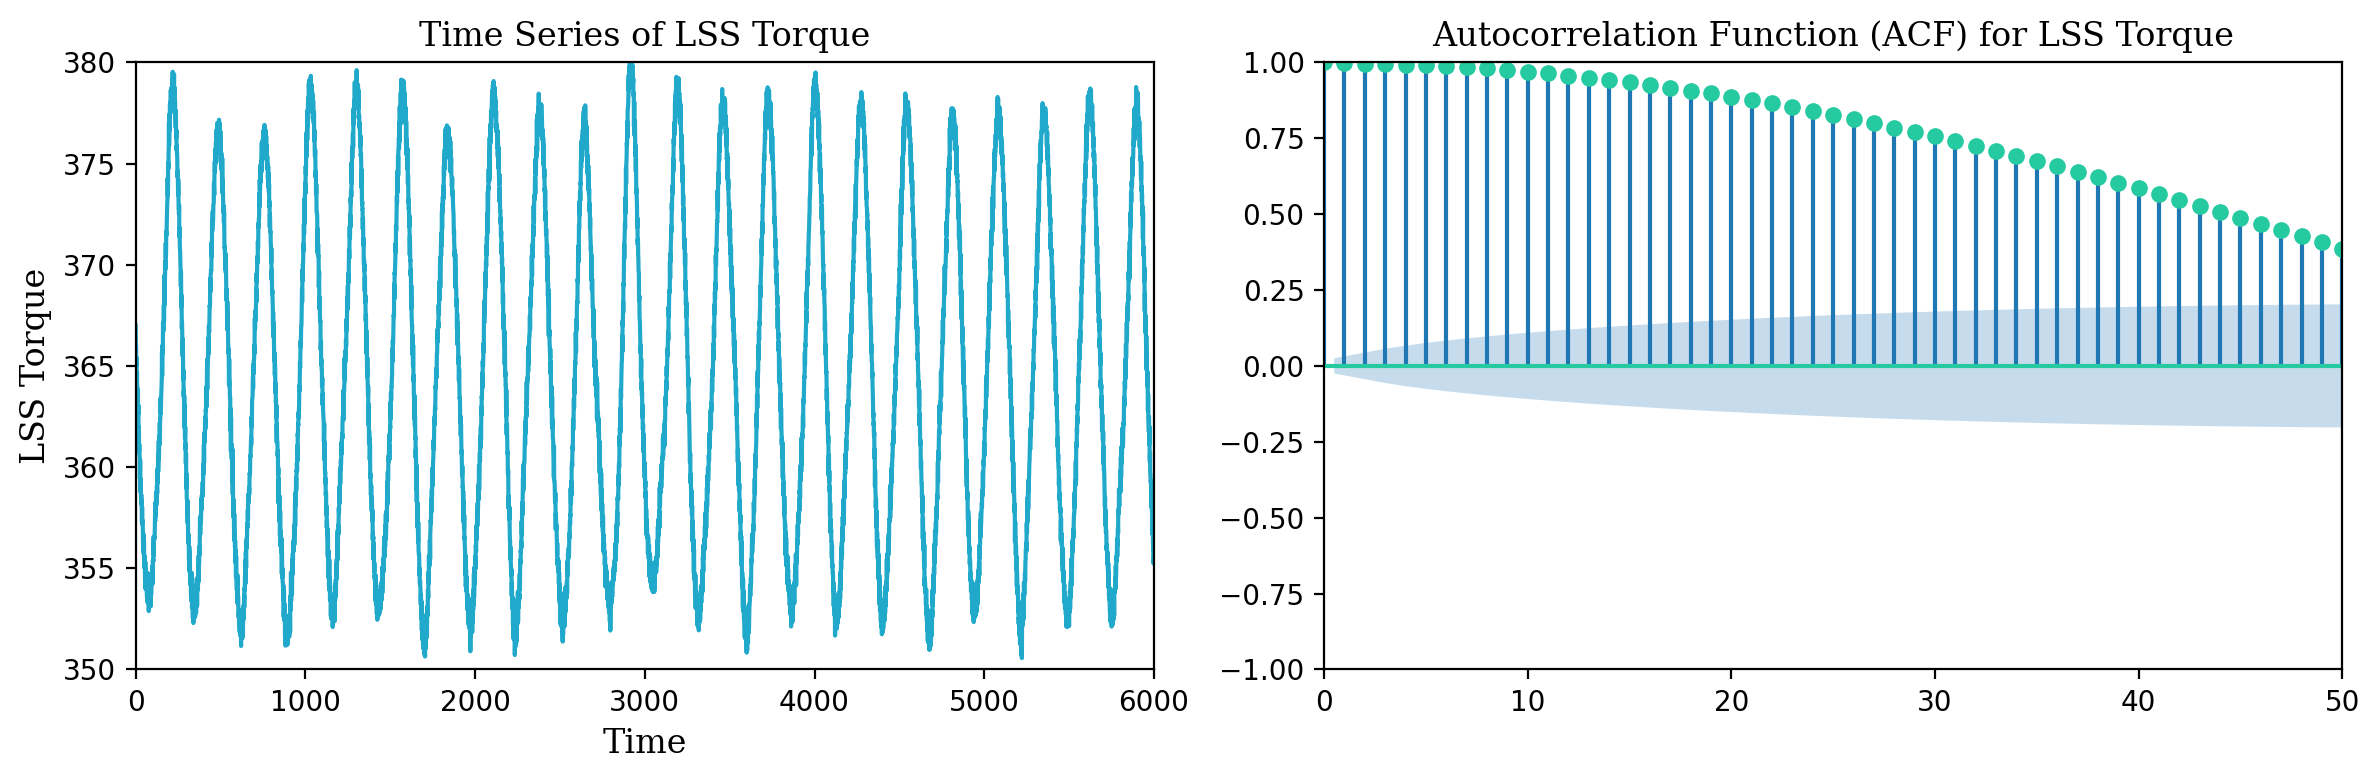

In [19]:
static_ntl_300kNm_slow_data = read_tdms(r"Data/5.2.1 Static NTL 100 Power/100% Power/SlowData/Static_NTL_7A_300kNm_2014_11_12_09_46_52_100Hz.tdms")

time_series = static_ntl_300kNm_slow_data['LSS_TQ']

fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=200)

# Plot the time series
axs[0].plot(time_series, color=colors[3])
axs[0].set_title('Time Series of LSS Torque', **hfont)
axs[0].set_xlabel('Time', **hfont)
axs[0].set_ylabel('LSS Torque', **hfont)
axs[0].set_xlim([0,6000])
axs[0].set_ylim([350,380])

# Plot ACF
plot_acf(time_series, lags=50, alpha=0.05, ax=axs[1], color=colors[2])  # Adjust 'lags' based on your data
axs[1].set_title('Autocorrelation Function (ACF) for LSS Torque', **hfont)
axs[1].set_xlim([0,50])
axs[1].set_ylim([-1,1])

plt.tight_layout()
plt.show()


The first plot shows the time series of the LSS torque. It indicates a strong periodic pattern. The regular peaks and troughs imply that the time series may have a fixed and known period.

The Autocorrelation Function plot shows how the time series data correlates with itself across different lags. The gradual decline in correlation as the lag increases is typical of a time series with high autocorrelation at short lags, which also suggests non-stationarity. The strong, sustained correlation across many lags, alongside the periodic spikes, reaffirms the periodicity observed in the time series plot.

These plots suggest forecasting this time series appears to be feasible given the clear patterns and strong periodicity. However, due to the non-stationarity, preprocessing steps such as differencing and possibly periodicity adjustment should be applied before building predictive models.

---

## An ensemble model containing dynamic & static loads, power shutdown, grid disconnect and misalignment that predicts reliability.

Reliability is challenging to predict without failure data, so indirect indicators of performance degradation are used as proxies for failure in approaching this problem. An ensemble model that combines an LSTM (Long Short-Term Memory) neural network and an Isolation Forest to identify anomalies in the dataset has been implemented. These anomalies could indicate abnormal gearbox behavior, which, in turn, could suggest a higher risk of failure. The strengths of both deep learning for sequence data and machine learning for identifying outliers are leveraged in this method.

In [4]:
# Function to create sequences for LSTM. This function creates windows of time-series data as input features.
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:(i + sequence_length)]
        sequences.append(sequence)
    return np.array(sequences)

# List of time series files. Misalignment, Static Loading, Dynamic Loading, and Power Shutdown
file_paths = ['Data/5.3 Generator Misalignment/0.5 Degree/No Tare/Misalignment_0P5_100P_2014_12_22_10_06_37_100Hz.tdms',               
                'Data/5.2.3 Static Thrust/SlowData/Static_Fx_6_100kN_2014_03_18_17_34_20_100Hz.tdms',
                'Data/5.2.2 Dynamic NTL/SlowData/Dynamic_NTL_3R_2014_03_18_11_55_54_100Hz.tdms', 
                'Data/5.2.1 Static NTL 100 Power/100% Power/SlowData/Static_NTL_7F_200kNm_2014_11_12_10_58_59_100Hz.tdms',
                'Data/5.4.2 Shutdown/HSS_BrakeTest_Thinpad_11_2015_01_07_11_11_05_100Hz.tdms']

all_sequences = []
all_differenced_trimmed_data = []
all_data = pd.DataFrame()

# This loop find common columns and preprocess each dataset
common_columns = None
for file_path in file_paths:
    df = read_tdms(file_path) # Load only the headers to find common columns
    if common_columns is None:
        common_columns = set(df.columns)
    else:
        common_columns.intersection_update(set(df.columns))
common_columns = list(common_columns)

# Preprocess and create sequences for each dataset for LSTM
scaler = MinMaxScaler()
sequence_length = 2*270  # Based on the periodicity in data. (2*period) 

for file_path in file_paths:
    df = read_tdms(file_path)[common_columns]
    df.drop(['MS Excel Timestamp', 'LabVIEW Timestamp', 'Scan Errors', 'Late Scans'], axis=1, inplace=True)
    all_data = pd.concat([all_data, df], ignore_index=True)
    data_normalized = scaler.fit_transform(df)
    sequences = create_sequences(data_normalized, sequence_length)
    all_sequences.append(sequences)
    
    # Difference the data to remove periodicity for training isolation forest
    differenced_trimmed = data_normalized[sequence_length:] - data_normalized[(sequence_length-1):-1]
    all_differenced_trimmed_data.append(differenced_trimmed)


# Combine sequences and differenced data from all files
combined_sequences = np.concatenate(all_sequences, axis=0)
combined_differenced_trimmed = np.concatenate(all_differenced_trimmed_data, axis=0)


# Split sequences into inputs and targets for LSTM
X_lstm = combined_sequences[:, :-1, :]
y_lstm = combined_sequences[:, -1, :]
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)



In [21]:
# LSTM Model architecture. 
# Aim is to predict the next step in the sequence. Large deviations in predictions and actual sensor readings could indicate anomalies.
model_lstm = Sequential([
    LSTM(50, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2]), return_sequences=True), 
    Dropout(0.2), # This layer randomly sets inputs to 0 with a frequency of 20% at each step, which helps prevent overfitting.
    LSTM(50, return_sequences=False), # 
    Dropout(0.2),
    Dense(y_lstm_train.shape[1])
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model_lstm.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=32, validation_data=(X_lstm_test, y_lstm_test))



Epoch 1/20


583/583 [==============================] - 155s 258ms/step - loss: 0.0511 - mae: 0.1737 - val_loss: 0.0239 - val_mae: 0.1144
Epoch 2/20
583/583 [==============================] - 146s 251ms/step - loss: 0.0261 - mae: 0.1226 - val_loss: 0.0156 - val_mae: 0.0890
Epoch 3/20
583/583 [==============================] - 146s 250ms/step - loss: 0.0214 - mae: 0.1097 - val_loss: 0.0140 - val_mae: 0.0838
Epoch 4/20
583/583 [==============================] - 146s 250ms/step - loss: 0.0196 - mae: 0.1043 - val_loss: 0.0130 - val_mae: 0.0799
Epoch 5/20
583/583 [==============================] - 143s 245ms/step - loss: 0.0182 - mae: 0.0999 - val_loss: 0.0123 - val_mae: 0.0774
Epoch 6/20
583/583 [==============================] - 148s 255ms/step - loss: 0.0171 - mae: 0.0967 - val_loss: 0.0115 - val_mae: 0.0741
Epoch 7/20
583/583 [==============================] - 147s 252ms/step - loss: 0.0163 - mae: 0.0940 - val_loss: 0.0114 - val_mae: 0.0740
Epoch 8/20
583/583 [========================

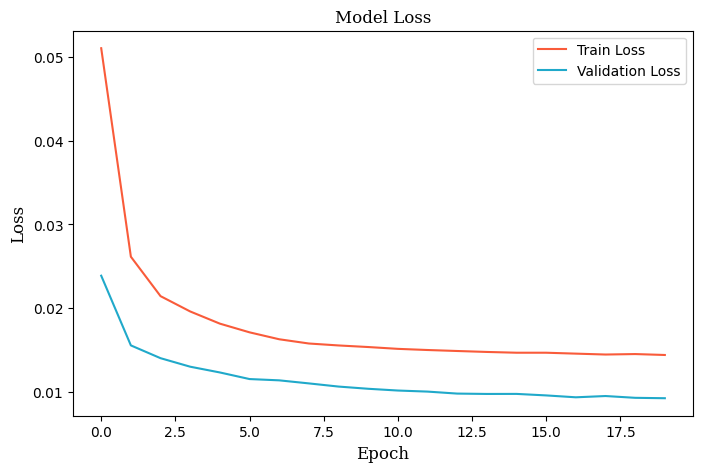

146/146 [==============================] - 12s 84ms/step
R-squared Score: 0.7766328627368801
Mean Absolute Error: 0.06551205608850007


In [25]:
# Plot training & validation loss values
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(history.history['loss'], label='Train Loss', color=colors[0])
plt.plot(history.history['val_loss'], label='Validation Loss', color=colors[3])
plt.title('Model Loss', **hfont)
plt.ylabel('Loss', **hfont)
plt.xlabel('Epoch', **hfont)
plt.legend(loc='upper right')
plt.show()


r2_lstm = r2_score(y_lstm_test, model_lstm.predict(X_lstm_test)) # Calculate R2 score of the LSTM model
mse_lstm = mean_squared_error(y_lstm_test, model_lstm.predict(X_lstm_test)) # Calculate Mean Squared Error of LSTM model
mae_lstm = mean_absolute_error(y_lstm_test, model_lstm.predict(X_lstm_test)) # Calculate Mean Absolute Error of LSTM model

print(f'R-squared Score: {r2_lstm}')
print(f'Mean Absolute Error: {mae_lstm}')


The R-squared score of 0.7766 and a Mean Absolute Error of 0.0655 indicate the model's accuracy in capturing the time series patterns. However, it can be further finetuned with feature engineering, hyperparameter tuning, a broader dataset including explicit failure instances, to refine predictions.

In [6]:
# Flatten the trimmed differenced data for Isolation Forest
X_iso = combined_differenced_trimmed.reshape(combined_differenced_trimmed.shape[0], -1)

# Isolation Forest Model
model_iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
model_iso.fit(X_iso)


IsolationForest(contamination=0.01, random_state=42)

In [15]:
# Get anomaly scores from LSTM and Isolation Forest model
lstm_predictions = model_lstm.predict(X_lstm)
lstm_scores = np.mean(np.abs(lstm_predictions - y_lstm), axis=1)
iso_scores = -model_iso.decision_function(X_iso)

# Following lines combine and normalize scores to get an average score. 
# Other methods of combining scores can also be used to further improve the resuts
combined_scores = (lstm_scores + iso_scores) / 2
threshold = np.quantile(combined_scores, 0.95)
anomalies = combined_scores > threshold

# The following lines add a column in the dataset indicating wether there is an anomaly in the data in the timestep.
all_data['Anomaly'] = False

anomaly_indices = np.where(anomalies)[0]

# Due to the indexing issue, we have one extra anomaly indicator at the end which we need to discard
all_data.loc[anomaly_indices[:-1], 'Anomaly'] = True

729/729 [==============================] - 50s 69ms/step


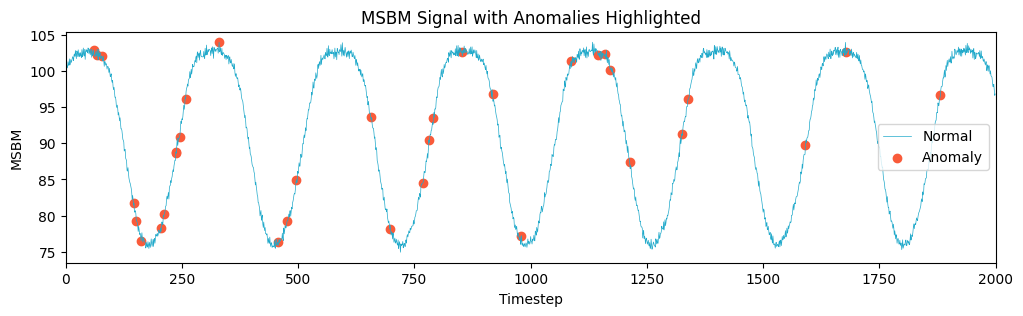

In [25]:
# Plot the Anomalies detected in Bending Moment Signal
plt.figure(figsize=(12, 3), dpi=100)
plt.plot(all_data.index[:2000], all_data['MSBM'][:2000], label='Normal', color=colors[3], linewidth=0.5)

# Overlay anomalies
anomalies = all_data[:2000][all_data[:2000]['Anomaly'] == True]
plt.scatter(anomalies.index, anomalies['MSBM'], label='Anomaly', color=colors[0])

plt.title('MSBM Signal with Anomalies Highlighted')
plt.xlabel('Timestep')
plt.ylabel('MSBM')
plt.xlim([0,2000])
plt.legend()
plt.show()